<a href="https://colab.research.google.com/github/hectorHardy/CM4107/blob/main/AICoursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

The ag_news dataset is a collection of 120000 news article excerpts paired with a numerical categorisation which represents one of the following four categories:


0: World


1: Sports


2: Business


3: Sci/Tech


The text articles are divided evenly between each of the categories and are all short form passages. In this project, an even sample of 5000 has been taken from the dataset in order to speed up processing time. The task at hand is text classification where the outcome is to predict the correct category of each article. This dataset is also appropriate for tasks such as text clustering and potentially sentiment analysis.


https://huggingface.co/datasets/fancyzhx/ag_news

In [1]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["train"])
sample = df.sample(n=5000)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
import numpy as np
import io
from google.colab import files

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, AutoModel
import torch

In [22]:
df

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2
...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0
119996,Renteria signing a top-shelf deal Red Sox gene...,1
119997,Saban not going to Dolphins yet The Miami Dolp...,1
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1


In [3]:
longest_item = "" # to calculate the average and max length of a news article.
max_length = 0
total_word_count = 0

for index, row in df.iterrows():
    text = row[0]
    word_count = len(text.split())
    total_word_count += word_count

    if len(text) > max_length:
        max_length = len(text)
        longest_item = text

average_word_count = total_word_count / len(df)

print("Longest headline:", longest_item)
print("Length of longest headline:", max_length)
print("Average word count:", average_word_count)

<ipython-input-3-f0f0a37ae16b>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[0]


Longest headline: Yahoo, SBC extend partnership, plan new services Yahoo and SBC Communications will collaborate to extend to cell phones and home entertainment devices some of the online services and content they currently provide to PC users.&lt;p&gt;ADVERTISEMENT&lt;/p&gt;&lt;p&gt;&lt;img src="http://ad.doubleclick.net/ad/idg.us.ifw.general/solaris;sz=1x1;ord=200301151450?" width="1" height="1" border="0"/&gt;&lt;a href="http://ad.doubleclick.net/clk;12204780;10550054;n?http://ad.doubleclick.net/clk;12165994;10522295;g?http://www.sun.com/solaris10"&gt;Solaris 10(TM) OS: Position your business ten moves ahead.&lt;/a&gt;&lt;br/&gt;Solaris 10 OS has arrived and provides even more\reasons for the world's most demanding businesses\to operate on this, the leading UNIX platform.\Like the fact you can run Linux and Solaris applications\side-by-side and run the same OS on SPARC(R),\AMD Opteron(TM), and Intel processor-based systems.\Discover more reasons and how Solaris 10 OS can move\your b

In [4]:
x = sample.iloc[:, 0].values
y = sample.iloc[:, 1].values

In [5]:
len(x)

5000

In [7]:
print(x_train[0])

Somerfield buys 114 Safeway outlets MORRISONS is to hand over 114 of its smaller Safeway stores to rival Somerfield as part of a 260m deal. Morrisons said the sale would let it concentrate on the larger Safeway stores that it acquired and 


In [8]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [9]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
print(len(x))

5000


**Representation Learning**

To learn reresentations, I have used a transformer from the hugging face library. This pre processes the news article strings beofre learning a numerical representation. Tokenisation is a pre processing technique used here which essentially shortens the words into small chunks. The input sequences are batched, which adds padding characters so each batch is the same size. We use the pre trained BERT model to tokenize before encoding and being fed to the hugging face autoModel. The mean pooling function is then applied to gain a weighted average of the token embeddings.

These representations are then used as input to the models in the next section.

In [7]:
# prep_text = []
# for z in sample.iloc[:, 0].values:
#     token_text = word_tokenize(z)

#     normd_text = [token.lower() for token in token_text]

#     swr_text = [token for token in normd_text if token not in stopwords.words('english')]

#     prep_text += [[WordNetLemmatizer().lemmatize(word) for word in swr_text]]

# prep_sentences = [" ".join(sentence) for sentence in prep_text]



0.8263999999999999

0.833

In [10]:
print(len(x))
print(len(y))

5000
5000


In [11]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")
encoded_input = tokenizer(list(x), padding=True, truncation=True, max_length=38, return_tensors='pt')
model = AutoModel.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")

with torch.no_grad():
    model_output = model(**encoded_input)

sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [12]:
print(sentence_embeddings)

tensor([[-0.4803,  0.9925, -0.1211,  ...,  0.0568,  0.5615, -0.1659],
        [-0.0072,  0.4292,  1.0444,  ..., -0.4760,  0.5067,  0.1894],
        [ 0.4906,  0.5846,  0.5958,  ...,  0.3609,  0.1893, -0.2537],
        ...,
        [-0.5358,  0.2807,  0.2009,  ..., -0.4023,  0.7905, -0.1294],
        [ 0.1982,  0.7469,  1.0237,  ..., -0.0621, -0.5076,  0.3093],
        [ 0.0113,  0.3765,  1.0203,  ..., -0.7706, -0.7035,  0.8410]])


**Algorithms**

Four algorithms have been used and compared in this project. They have been compared with several different metrics. The models are K-nearest neighbors, Support vector machine, Multilayer perceptron and transformers(roBERTa).

Knn measures the distance of a new item to existing ones to decide the category it most likely will fit into. The number of neighbours(k) that are compared against can be modified, as well as the method of comparison.

a mlp is another model that can be used for text clasification. being a type of artificial nueral network, the consits of a single input and output layer as well as multiple hidden layers. In our case, words are converted into a vectorized form, they can be sent into the input layer. the hidden layers use weights and biases applied to the inputs, attempting to separate the data in each class to make it easily seperable, especially when the separation is non-linear. The output layer uses a softmax function to finally achieve this; it is a vector ofprobabilities.

svm is another machine learning algorithm used for text clasification. the input text is pre processed, much like the other algorithms, using techniques such as tokenisation. in a similar way to knn, this is an instance based learner which may their predictions based upon new and existing data. The difference is that svm tries to create a seperation between categories by dividing them with a line/plane with the largest margin possible.

roBERTa is a transformer which combines encoding and decoding information. The input text is encoded into a numerical representation which is then decoded into output text. these types of modles are pre trained on lots of data. RoBERTa was trained on over 160GB of data, form wikipedia to news databases. This model is also bidirectional, meaning that input text is processed from right to left as well as left to right. This function should help it lead to better understanding and a more accurate seperation of categories. The fact that it was trained on a large news dataset may help the accuracy of this model in this instance.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [14]:
x_train, x_test, y_train, y_test = sentence_embeddings[train], sentence_embeddings[test], y[train], y[test]

mlp = MLPClassifier(hidden_layer_sizes=(64,))

parameters = {"solver":["adam", "sgd"], "activation":["relu", "tanh"], "batch_size":[8, 32, 64], "max_iter":[5, 10, 20]}
clf = GridSearchCV(mlp, parameters, scoring="accuracy")
clf.fit(sentence_embeddings, y)

print(clf.best_params_)
print(clf.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690

{'activation': 'tanh', 'batch_size': 32, 'max_iter': 20, 'solver': 'sgd'}
0.8767999999999999


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:
kNN = KNeighborsClassifier(n_neighbors=3)

parameters = {"weights":["uniform", "distance"], "p":[1, 2], "n_neighbors":[1, 3, 6]}
clf = GridSearchCV(kNN, parameters, scoring="accuracy")
clf.fit(sentence_embeddings, y)

print(clf.best_params_)
print(clf.best_score_)

{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
0.8293999999999999


In [18]:


knn_score = []
knn_f1 = []
mlp_score = []
mlp_f1 = []
svc_score = []
svc_f1 = []

kf = StratifiedKFold(n_splits=5)

for train, test in kf.split(sentence_embeddings,y):

  x_train, x_test, y_train, y_test = sentence_embeddings[train], sentence_embeddings[test], y[train], y[test]

  kNN = KNeighborsClassifier(n_neighbors=6, p=1, weights="distance")
  kNN.fit(x_train, y_train)
  knn_predictions = kNN.predict(x_test)
  knn_acc = accuracy_score(knn_predictions, y_test)
  knn_report = classification_report(y_test, knn_predictions, output_dict=True)
  knn_score.append(knn_acc)
  knn_probs = kNN.predict_proba(x_test)
  knn_f1.append(roc_auc_score(y_test, knn_probs, multi_class='ovr'))
  cmKnn = confusion_matrix(y_test, knn_predictions)
  print(cmKnn)
  # print("KNN Classification Report:")
  # print(knn_report)

  mlp = MLPClassifier(activation="tanh", batch_size = 32, max_iter=20, solver="sgd")
  mlp.fit(x_train, y_train)
  mlp_predictions = mlp.predict(x_test)
  mlp_acc = accuracy_score(mlp_predictions, y_test)
  mlp_report = classification_report(y_test, mlp_predictions, output_dict=True)
  mlp_score.append(mlp_acc)
  mlp_probs = mlp.predict_proba(x_test)
  mlp_f1.append(roc_auc_score(y_test, mlp_probs, multi_class='ovr'))
  cmMlp = confusion_matrix(y_test, mlp_predictions)
  print(cmMlp)
  # print("MLP Classification Report:")
  # print(mlp_report)

  svm = SVC(kernel='linear', probability = True)
  svm.fit(x_train, y_train)
  svc_predictions = svm.predict(x_test)
  svc_acc = accuracy_score(svc_predictions, y_test)
  svc_report = classification_report(y_test, svc_predictions, output_dict=True)
  svc_score.append(svc_acc)
  svc_probs = svm.predict_proba(x_test)
  svc_f1.append(roc_auc_score(y_test, svc_probs, multi_class='ovr'))
  cmSvc = confusion_matrix(y_test, svc_predictions)
  print(cmSvc)
  # print("SVC Classification Report:")
  # print(scv_report)

print("kNN Accuracy:", np.mean(knn_score), " MLP Accuracy:", np.mean(mlp_score), " SVC Accuracy:", np.mean(svc_score))
print("kNN F1:", np.mean(knn_f1), " MLP F1:", np.mean(mlp_f1), " SVC F1:", np.mean(svc_f1))

[[185  13  29  14]
 [  7 229  12   3]
 [ 14   3 204  29]
 [ 12   2  40 204]]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


[[209  11  10  11]
 [  1 244   4   2]
 [ 13   3 211  23]
 [  6   1  29 222]]
[[207  11  11  12]
 [ 14 234   2   1]
 [ 25   6 191  28]
 [ 13   1  30 214]]
[[193   9  35   4]
 [ 13 229   5   4]
 [ 15   7 203  25]
 [ 11   5  48 194]]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


[[210  10  14   7]
 [  8 239   4   0]
 [ 11   6 206  27]
 [  8   2  38 210]]
[[198  12  16  15]
 [ 12 233   5   1]
 [ 23   4 200  23]
 [ 19   5  42 192]]
[[195  20  19   7]
 [  6 226  10   9]
 [  6   7 197  40]
 [ 17   3  28 210]]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


[[209  15  11   6]
 [ 10 234   3   4]
 [ 17   5 197  31]
 [ 16   1  23 218]]
[[201  19  17   4]
 [ 10 230   8   3]
 [ 24   3 189  34]
 [ 24   1  36 197]]
[[202  10  15  15]
 [  7 230  11   3]
 [ 10   5 204  30]
 [ 17   2  39 200]]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


[[211   9   7  15]
 [  3 244   2   2]
 [  5   1 208  35]
 [ 16   4  17 221]]
[[202  11  13  16]
 [ 12 233   4   2]
 [ 16   1 201  31]
 [ 18   3  31 206]]
[[193   6  35   8]
 [  3 237   9   3]
 [ 14   4 199  32]
 [  8   5  31 213]]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


[[208   7  16  11]
 [  7 244   1   0]
 [ 10   6 201  32]
 [  5   4  22 226]]
[[207   5  17  13]
 [ 18 232   1   1]
 [ 18   5 188  38]
 [ 17   4  27 209]]
kNN Accuracy: 0.8293999999999999  MLP Accuracy: 0.8744  SVC Accuracy: 0.8328
kNN F1: 0.9474882811614191  MLP F1: 0.9714608392941791  SVC F1: 0.9605316183688084


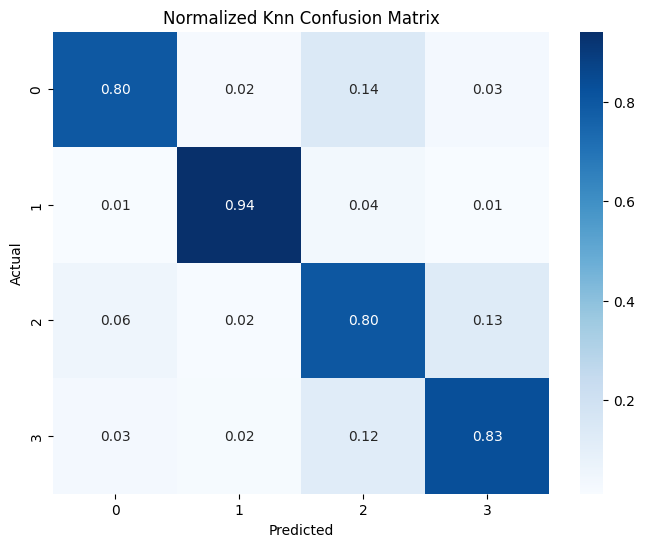

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_norm = cmKnn / cmKnn.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Knn Confusion Matrix')
plt.show()

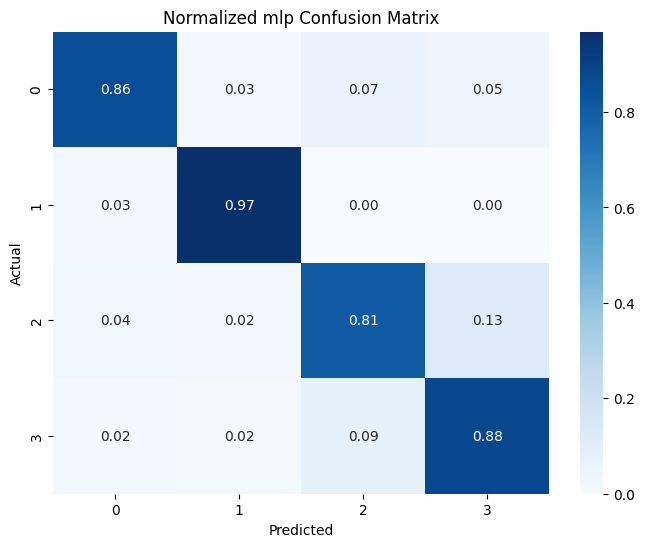

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_norm = cmMlp / cmMlp.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized mlp Confusion Matrix')
plt.show()

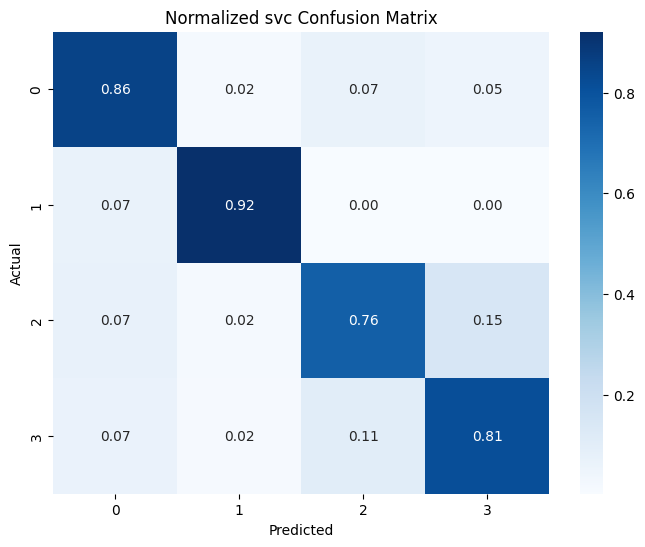

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_norm = cmSvc / cmSvc.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized svc Confusion Matrix')
plt.show()

[Text(1, 0, 'knn'), Text(2, 0, 'mlp'), Text(3, 0, 'svc')]

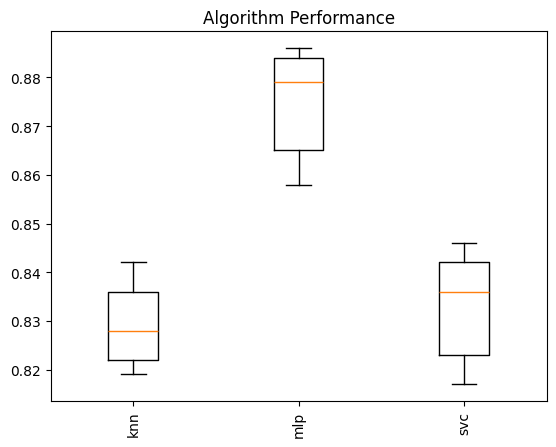

In [22]:
import matplotlib as plt

model_comp = []
model_comp.append(knn_score)
model_comp.append(mlp_score)
model_comp.append(svc_score)

fig, ax2 = plt.pyplot.subplots()
ax2.set_title('Algorithm Performance')
ax2.boxplot(model_comp)
ax2.set_xticklabels(['knn', 'mlp', 'svc'], rotation='vertical')

This compares the accuracy score between the knn, mlp and svc models.

In [16]:
!pip install transformers datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [23]:
#using roBERTa for text classification

#Using the suggested preprocessing for this method:

from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [34]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

new_sample = sample.set_axis(['text', 'label'], axis=1, copy=False)
dataset = Dataset.from_pandas(new_sample[['text', 'label']])
tokenized_sample = dataset.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")

id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
label2id = {"World": 0, "Sports": 1, "Business": 2, "Sci/Tech": 3}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=4, id2label=id2label, label2id=label2id
)

training_args = TrainingArguments(
    output_dir="roBERTA_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

train_testvalid = tokenized_sample.train_test_split(test_size=0.2)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_testvalid["train"],
    eval_dataset=train_testvalid["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.316222,0.902000
2,0.387700,0.292885,0.915000


TrainOutput(global_step=500, training_loss=0.38774725341796873, metrics={'train_runtime': 12426.1749, 'train_samples_per_second': 0.644, 'train_steps_per_second': 0.04, 'total_flos': 543913979632128.0, 'train_loss': 0.38774725341796873, 'epoch': 2.0})

Epoch |	Training Loss |	Validation Loss	| Accuracy

1 	|  No log	  |    0.316222	   |   0.902000

2	  |  0.387700	 |   0.292885	  |   0.915000

TrainOutput(global_step=500, training_loss=0.38774725341796873, metrics={'train_runtime': 12426.1749, 'train_samples_per_second': 0.644, 'train_steps_per_second': 0.04, 'total_flos': 543913979632128.0, 'train_loss': 0.38774725341796873, 'epoch': 2.0})

In [37]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


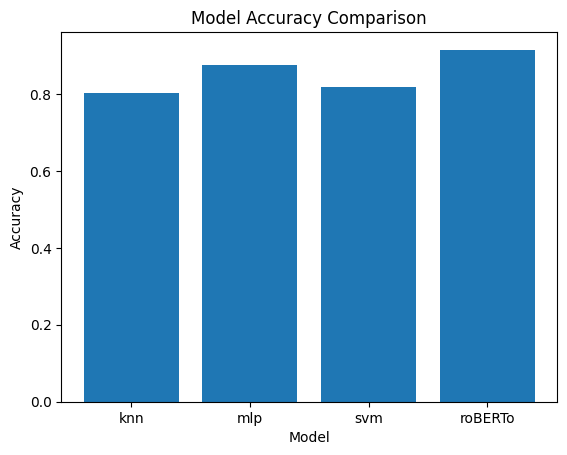

In [39]:
model_accuracy = [0.8032, 0.8746, 0.8170, 0.9150]
model_names = ["knn", "mlp", "svm", "roBERTo"]

import matplotlib.pyplot as plt

plt.bar(model_names, model_accuracy)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

**Evaluation**


There are three separate sections to compare above. The first is a set of three heat maps/confusion matrices produced from the roc_auc_score module from sklearn.metrics. It collects data on the false and true positives found in each of the models. They all show that the models produce very few false positives across the board. Saying this, a common trend can be seen where the models seem to occasionally predict a business article to be a sci/Tech article and vice versa. The most precise category is sports, probably as it is very different from the other three which share certain similarities.


The second section looks at the accuracy scores calculated in each of the three models. The box plot shows that the mlp both outperforms the other algorithms in terms of accuracy, but also has a tighter spread of values. This suggests that the mlp model is less sensitive to changes in data seen in each fold.


The last section adds in a fourth model for comparison and again is compared using accuracy scores. The model in question is roBERTa which is a transformer based and improved upon BERT. It can be seen that this model outperforms all others in terms of accuracy score. Due to the balanced dataset, this shows that roBERTa is making correct predictions most of the time.
